#  Predicting Global Food Shortages Based on Climate and Socioeconomic Factors Utilizing Machine Learning Models

## Novelty of This Project

<b>International</b>: Previous research is largely trained on specific regions of the world. This research utilizes a dataset that spans the whole world, with countries from every continent.

<b>Combination of Climatic and Socioeconomic Factors</b>: This research combines environmental and socioeconomic features as the inputs in determining food shortage while most other models are narrowed to one of the two categories. 

## Model Inputs and Outputs

For each machine learning model that is implemented, the same data is used for training and testing.

### Inputs
Percentage of land covered by Forest<br>
Fertilizer in kilograms per hectare<br>
Amount of land used for harvesting crops in hectares (normalized over country area)<br>
Amount of land used for irrigation in hectares (normalized over country area)<br>
Temperature in degrees Celsius<br>
GDP in millions of US Dollars<br>

### Output

Binary Variable: 0 = Food Secure, 1 = Food Shortage<br>
This is calculated based on the Food Availability per Capita in kilocalories<br>
if Food Availability >= 1800 kCal : Food Secure<br>
if Food Availability < 1800 kCal : Food Shortage<br>

In [11]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

year_start = 2002
year_end = 2016
wheat_conversion = 3400 #kCals per 1kg of wheat
insecure_threshold = 1800 #must have 1800 Cal/capita/day to be food secure

raw_data_dir = "For_Preprocessing"

usda_raw_dir = "USDA_Crop_Yield_Food_Availabity_Per_Capita"
usda_raw_filename = "gfa25.csv"

wb_ag_raw_dir = "World_Bank_Agricultural_Land"
wb_ag_raw_filename = "API_AG.LND.AGRI.K2_DS2_en_csv_v2_1744410.csv"

forest_raw_dir = "World_Bank_Forest_Land_Percent"
forest_raw_filename = "API_AG.LND.FRST.ZS_DS2_en_csv_v2_1740159.csv"

fert_raw_dir = "World_Bank_Fertilizer_Consumption"
fert_raw_filename = "API_AG.CON.FERT.ZS_DS2_en_csv_v2_1742242.csv"

irrig_raw_dir = "UN_Data_Land_equipped_for_irrigation"
irrig_raw_filename = "UNdata_Export_20201208_035525050.csv"

temper_raw_dir = "Berkeley_Earth_Temperature"
temper_raw_filename = "GlobalLandTemperaturesByCountry.csv"

areas_raw_dir = "Kaggle_Country_Areas"
areas_raw_filename = "countries.csv"

#Read in USDA data
usda_raw_filepath = os.path.join(raw_data_dir, usda_raw_dir, usda_raw_filename)
df_usda = pd.read_csv(usda_raw_filepath,index_col=None, encoding='latin-1')

#Read in WB Agricultural Land data: Back Up
# wb_ag_raw_filepath = os.path.join(raw_data_dir, wb_ag_raw_dir, wb_ag_raw_filename)
# df_agri = pd.read_csv(wb_ag_raw_filepath,index_col=None, encoding='latin-1', header = 4)

#Read in Forest Land Percentage data
forest_raw_filepath = os.path.join(raw_data_dir, forest_raw_dir, forest_raw_filename)
df_forest = pd.read_csv(forest_raw_filepath,index_col=None, encoding='latin-1', header = 2)

#Read in Fertilizer Usage data
fert_raw_filepath = os.path.join(raw_data_dir, fert_raw_dir, fert_raw_filename)
df_fert = pd.read_csv(fert_raw_filepath,index_col=None, encoding='latin-1', header = 2)

#Read in Irrigation data
irrig_raw_filepath = os.path.join(raw_data_dir, irrig_raw_dir, irrig_raw_filename)
df_irrig = pd.read_csv(irrig_raw_filepath,index_col=None, encoding='latin-1')

#Read in Temperature data
temper_raw_filepath = os.path.join(raw_data_dir, temper_raw_dir, temper_raw_filename)
df_temper = pd.read_csv(temper_raw_filepath,index_col=None, encoding='latin-1')
df_temper[['Year','Month', 'First Day']] = df_temper.dt.str.split("-",expand=True) 

#Read in Area data
areas_raw_filepath = os.path.join(raw_data_dir, areas_raw_dir, areas_raw_filename)
df_areas = pd.read_csv(areas_raw_filepath,index_col=None, encoding='latin-1')

#extract unique country names
unique_country_names = df_usda.Country.unique()
total_row_cnt = len(unique_country_names)*(year_end-year_start+1)
df_post = pd.DataFrame(index=range(0,total_row_cnt), columns=['country', 'year', 'forest_land', 'fertilizer', 
                                                              'area_harvested','harvest_area_norm','irrigation','irrigation_norm','temperature', 
                                                              'precipitation', 'GDP','Food_Availability_PC',
                                                              'Daily_Caloric_Intake', 'Food_Insecure'])
row_count = 0
for country in unique_country_names:
    
    temp = df_areas.loc[df_areas['Country'].str.strip() == country, 'Area (sq. mi.)']
    country_area = -1
    if not temp.empty:
            country_area = temp.iloc[0]
    country_area = country_area * 258.999 #convert to Hecta
    #print('Name: ', country)
    #print('Country Area HA: ', country_area)
    for year in range(year_start, year_end+1):
        df_post.iloc[row_count]['country'] = country
        df_post.iloc[row_count]['year'] = year
        
        temp = df_usda.loc[(df_usda['Country'] == country) & (df_usda['Year'] == year) & (df_usda['Commodity'] == 'Total Grains/Cereals') & (df_usda['Item'] == 'Area Harvested'), 'Amount']
        if not temp.empty:
            df_post.iloc[row_count]['area_harvested'] = temp.iloc[0] 
            df_post.iloc[row_count]['harvest_area_norm'] = temp.iloc[0]/country_area
            
        temp = df_usda.loc[(df_usda['Country'] == country) & (df_usda['Year'] == year) & (df_usda['Commodity'] == 'Economic Data') & (df_usda['Item'] == 'GDP (constant 2005 US$)'), 'Amount']
        if not temp.empty:
            df_post.iloc[row_count]['GDP'] = temp.iloc[0] 
            
        temp = df_usda.loc[(df_usda['Country'] == country) & (df_usda['Year'] == year) & (df_usda['Commodity'] == 'Total Grains/Cereals') & (df_usda['Item'] == 'Food Availability per capita'), 'Amount']
        if not temp.empty:
            df_post.iloc[row_count]['Food_Availability_PC'] = temp.iloc[0]
        
        temp = df_forest.loc[(df_forest['Country Name'] == country), str(year)]
        if not temp.empty:
            df_post.iloc[row_count]['forest_land'] = temp.iloc[0]
            
        temp = df_fert.loc[(df_forest['Country Name'] == country), str(year)]
        if not temp.empty:
            df_post.iloc[row_count]['fertilizer'] = temp.iloc[0]
            
        temp = df_irrig.loc[(df_irrig['Country or Area'] == country) & (df_irrig['Year'] == year), 'Value']
        if not temp.empty:
            df_post.iloc[row_count]['irrigation'] = temp.iloc[0]
            df_post.iloc[row_count]['irrigation_norm'] = temp.iloc[0]/country_area
        
        temp = df_temper.loc[(df_temper['Country'] == country) & (df_temper['Year'] == str(year)), 'AverageTemperature']
        if not temp.empty:
            df_post.iloc[row_count]['temperature'] = temp.mean()
        
        temp = df_post.iloc[row_count]['Food_Availability_PC']
        df_post.iloc[row_count]['Daily_Caloric_Intake'] = (temp/365)*wheat_conversion
        
        df_post.iloc[row_count]['Food_Insecure'] = 0
        if df_post.iloc[row_count]['Daily_Caloric_Intake'] < insecure_threshold:
            df_post.iloc[row_count]['Food_Insecure'] = 1
        row_count = row_count + 1
        
df_post.to_csv('data.csv')


In [12]:
df_post

,country,year,forest_land,fertilizer,area_harvested,harvest_area_norm,irrigation,irrigation_norm,temperature,precipitation,GDP,Food_Availability_PC,Daily_Caloric_Intake,Food_Insecure
0,Algeria,2002,0.655739,9.64158,1845.11,2.99108e-06,650,1.05371e-06,24.263,NaN,87156.3,223.774,2084.47,0
1,Algeria,2003,0.652128,6.00117,2901.56,4.7037e-06,785,1.27256e-06,24.3937,NaN,93431.6,226.644,2111.21,0
2,Algeria,2004,0.648517,25.0952,3000.6,4.86425e-06,860,1.39414e-06,23.916,NaN,97449.2,227.581,2119.93,0
3,Algeria,2005,0.644907,7.4299,2350.51,3.8104e-06,980,1.58867e-06,24.2226,NaN,103199,229.619,2138.91,0
4,Algeria,2006,0.676984,13.2627,2672.16,4.33181e-06,1000,1.62109e-06,24.2008,NaN,104953,231.493,2156.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,Peru,2012,58.1842,94.2501,1258.35,3.7803e-06,2580,7.75076e-06,20.46,NaN,127557,149.709,1394.55,1
1136,Peru,2013,58.0533,94.9095,NaN,NaN,2600,7.81084e-06,19.9763,NaN,NaN,150.801,1404.72,1
1137,Peru,2014,57.9223,112.673,NaN,NaN,2600,7.81084e-06,NaN,NaN,NaN,NaN,NaN,0
1138,Peru,2015,57.7914,141.298,NaN,NaN,2600,7.81084e-06,NaN,NaN,NaN,NaN,NaN,0


Order of the Maps:
1. Food Availability in Year  2012
2. Food Shortage or Secure in Year  2012
3. Forest Land Percentage in Year  2012
4. Fertilizer Usage in Year  2012
5. Harvest Land Area in Year  2012
6. Irrigation Land in Year  2012
7. Temperature in Year  2012
8. GDP in Year  2012


/Users/isitatalukdar/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:1714: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(ms, UserWarning)
/Users/isitatalukdar/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:1715: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % uvk, UserWarning)


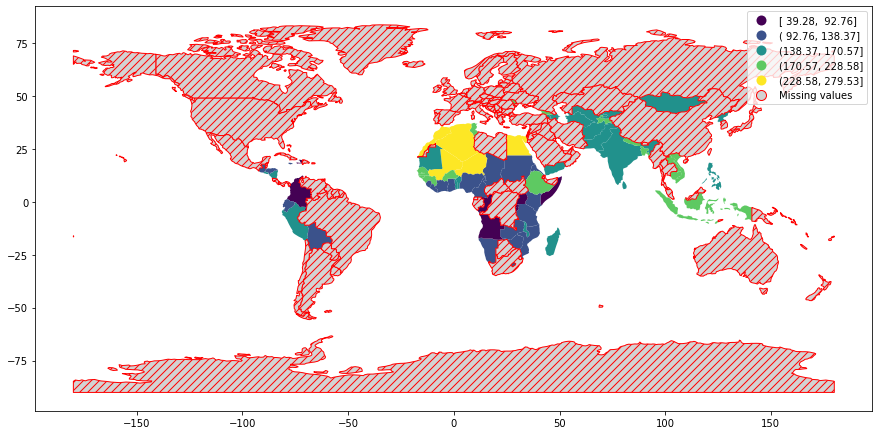

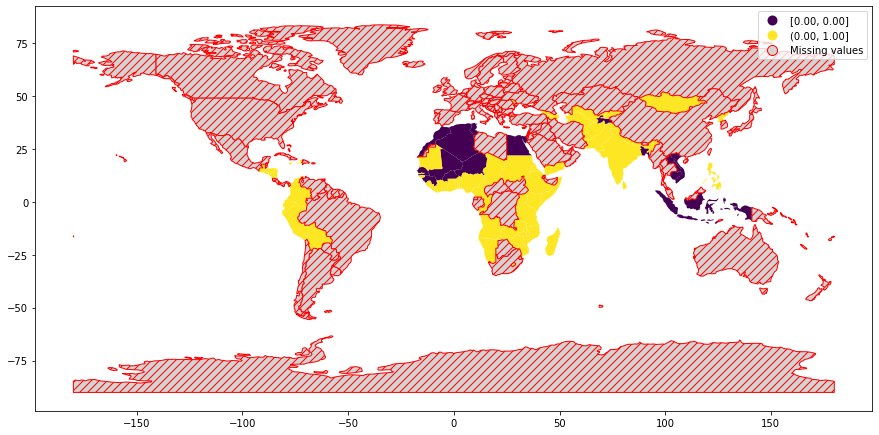

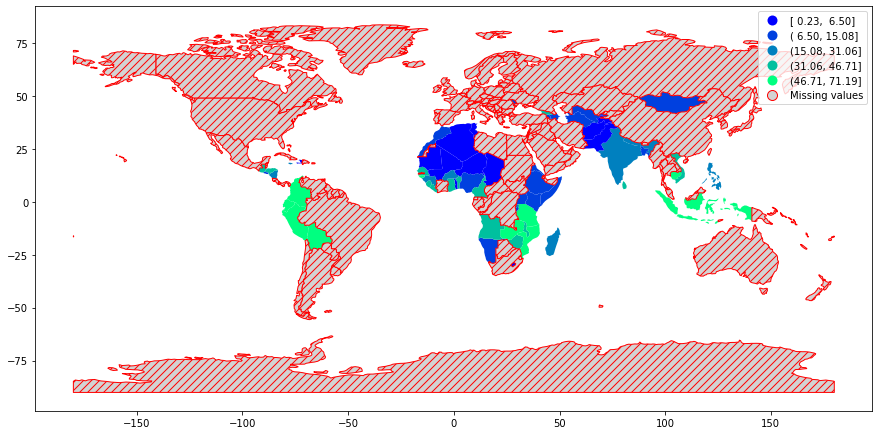

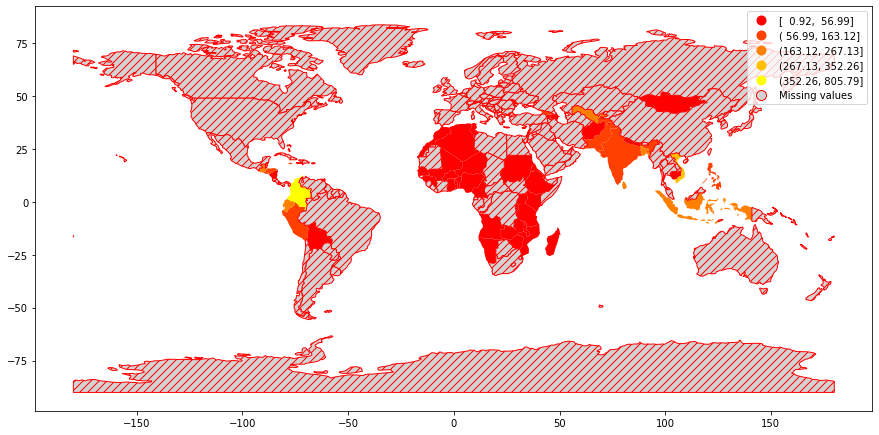

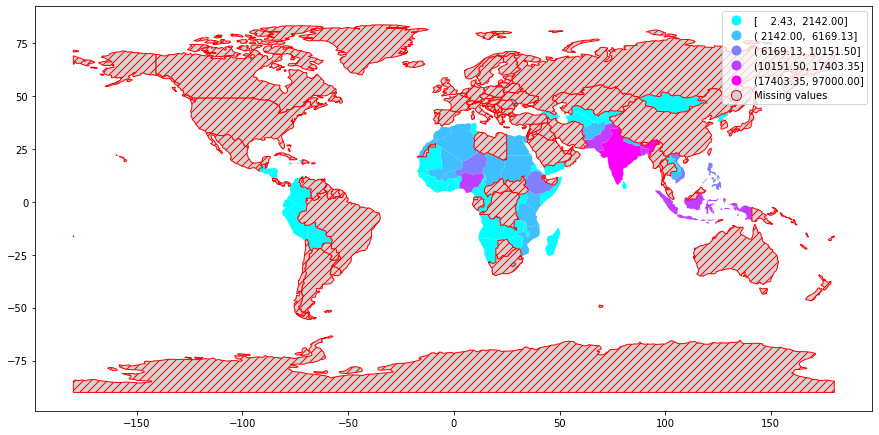

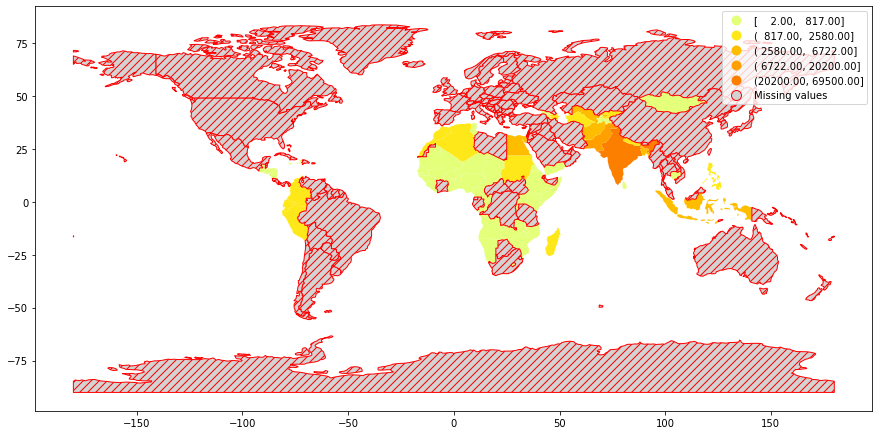

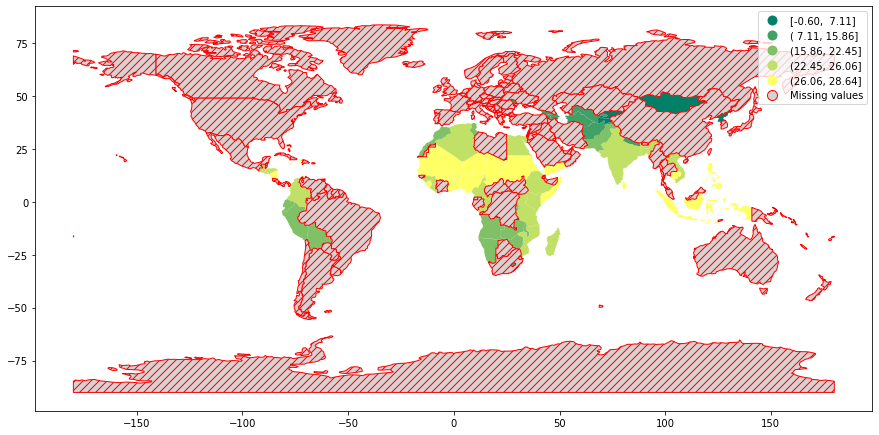

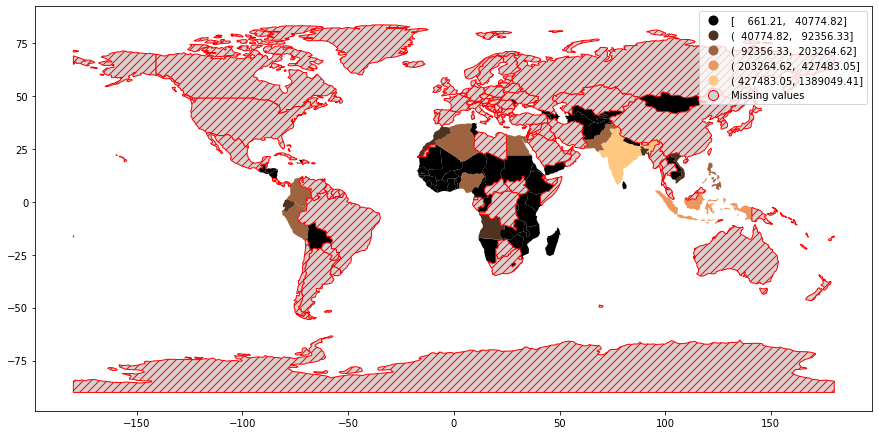

In [13]:
import geopandas
import geoplot

world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
boroughs = geopandas.read_file(
    geoplot.datasets.get_path('nyc_boroughs')
)
collisions = geopandas.read_file(
    geoplot.datasets.get_path('nyc_injurious_collisions')
)

year = 2012
name = "Food_Availability_PC_" + str(year)
name1 = "Food_Insecure" + str(year)
for_land = "Forest_Land" + str(year)
fertilizer = "Fertilizer" + str(year)
har_ar = "Harvest_Area" + str(year)
irrig = "Irrigation" + str(year)
temperature = "Temperature" + str(year)
gdp = "GDP" + str(year)
row_count = 0
for country in list(world["name"]):
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'Food_Availability_PC']
    if not temp.empty:
            world.loc[row_count, name] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'Food_Insecure']
    if not temp.empty:
            world.loc[row_count, name1] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'forest_land']
    if not temp.empty:
            world.loc[row_count, for_land] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'fertilizer']
    if not temp.empty:
            world.loc[row_count, fertilizer] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'area_harvested']
    if not temp.empty:
            world.loc[row_count, har_ar] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'irrigation']
    if not temp.empty:
            world.loc[row_count, irrig] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'temperature']
    if not temp.empty:
            world.loc[row_count, temperature] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'GDP']
    if not temp.empty:
            world.loc[row_count, gdp] = temp.iloc[0]
    row_count = row_count + 1
    

print("Order of the Maps:")
print("1. Food Availability in Year ", year)
print("2. Food Shortage or Secure in Year ", year)
print("3. Forest Land Percentage in Year ", year)
print("4. Fertilizer Usage in Year ", year)
print("5. Harvest Land Area in Year ", year)
print("6. Irrigation Land in Year ", year)
print("7. Temperature in Year ", year)
print("8. GDP in Year ", year)
world.plot(
    column=name,
    legend=True,
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=name1,
    legend=True,
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=for_land,
    legend=True,
    cmap = 'winter',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=fertilizer,
    legend=True,
    cmap = 'autumn',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=har_ar,
    legend=True,
    cmap = 'cool',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=irrig,
    legend=True,
    cmap = 'Wistia',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=temperature,
    legend=True,
    cmap = 'summer',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=gdp,
    legend=True,
    cmap = 'copper',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

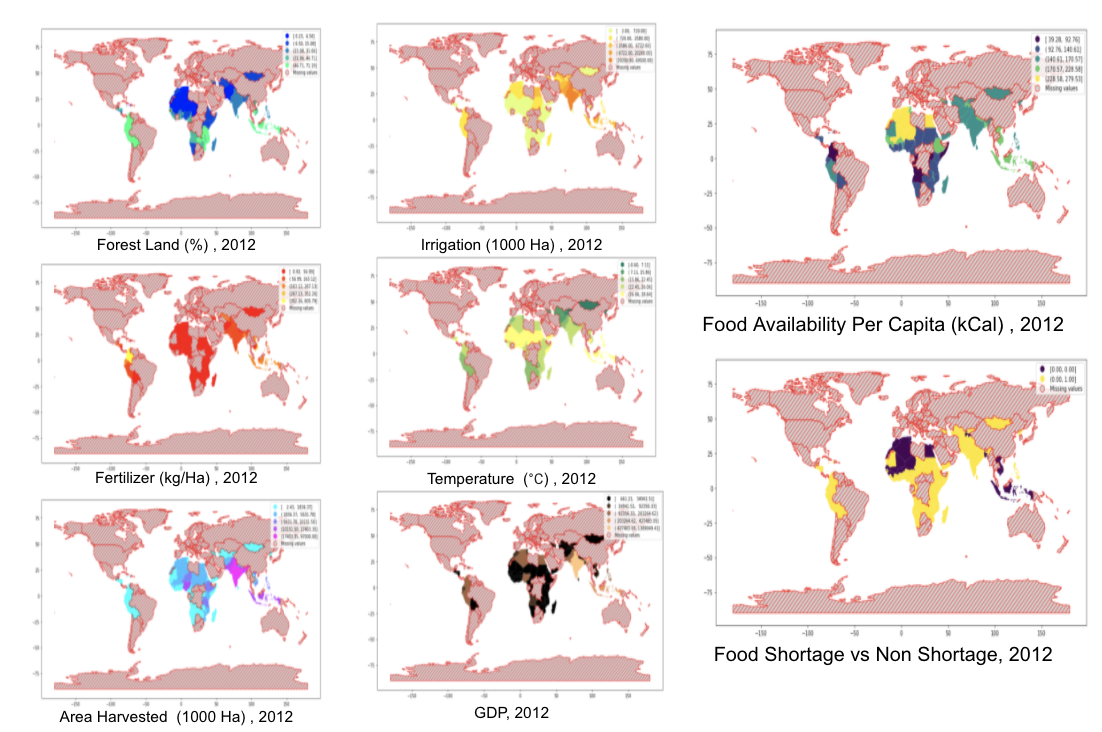